In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import cv2 as cv2
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import PIL

In [2]:
df = pd.read_csv('../data/interim/file_dataframe.csv')

In [3]:
avgs = []
d_rgb = []
d2_rgb = []
for f in df.file_path[:]:
    n_colors = 2
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    avgs.append(sum(im.mean(axis=0))/600)
    pixels = np.float32(im.reshape(-1, 3))
    n_colors = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    d_rgb.append(palette[0])
    d2_rgb.append(palette[1])
rgb = []
for a in avgs:
    rgb.append([a[0], a[1], a[2]])

In [4]:
def fe(t_df):
    df['r'] = np.array(rgb)[:, 0]
    df['g'] = np.array(rgb)[:, 1]
    df['b'] = np.array(rgb)[:, 2]
    df['dr'] = np.array(d_rgb)[:, 0]
    df['dg'] = np.array(d_rgb)[:, 1]
    df['db'] = np.array(d_rgb)[:, 2]
    df['d2r'] = np.array(d2_rgb)[:, 0]
    df['d2g'] = np.array(d2_rgb)[:, 1]
    df['d2b'] = np.array(d2_rgb)[:, 2]
    df['r_g_diff'] = df['r'] - df['g']
    df['r_b_diff'] = df['r'] - df['b']
    df['g_b_diff'] = df['g'] - df['b']
    df['g_r_diff'] = df['g'] - df['r']
    df['b_g_diff'] = df['b'] - df['g']
    df['b_r_diff'] = df['b'] - df['r']
    return t_df
df = fe(df)

In [92]:
df.head()

,file_path,category,r,g,b,dr,dg,db,d2r,d2g,d2b,r_g_diff,r_b_diff,g_b_diff,g_r_diff,b_g_diff,b_r_diff
0,../data/raw/AID/Pond/pond_251.jpg,Pond,71.581731,73.062497,58.269119,50.187180,57.997398,43.573582,121.893410,108.489761,92.827316,-1.480767,13.312611,14.793378,1.480767,-14.793378,-13.312611
1,../data/raw/AID/Pond/pond_245.jpg,Pond,78.325014,83.211397,67.768533,70.436035,76.380867,60.865246,131.990875,129.511902,114.855461,-4.886383,10.556481,15.442864,4.886383,-15.442864,-10.556481
2,../data/raw/AID/Pond/pond_24.jpg,Pond,110.961311,127.549942,133.984675,129.887924,148.485718,150.221603,88.613731,102.837074,114.814034,-16.588631,-23.023364,-6.434733,16.588631,6.434733,23.023364
3,../data/raw/AID/Pond/pond_30.jpg,Pond,124.829981,134.833172,134.062681,145.285538,151.911514,148.957993,88.906403,104.838066,107.900208,-10.003192,-9.232700,0.770492,10.003192,-0.770492,9.232700
4,../data/raw/AID/Pond/pond_18.jpg,Pond,90.028836,98.155272,100.570919,111.261589,123.796814,117.583122,62.889439,65.383438,78.825859,-8.126436,-10.542083,-2.415647,8.126436,2.415647,10.542083


In [6]:
le = LabelEncoder()
y = le.fit_transform(df['category'])
X = df.drop(['file_path', 'category'], axis = 1)

In [118]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2)

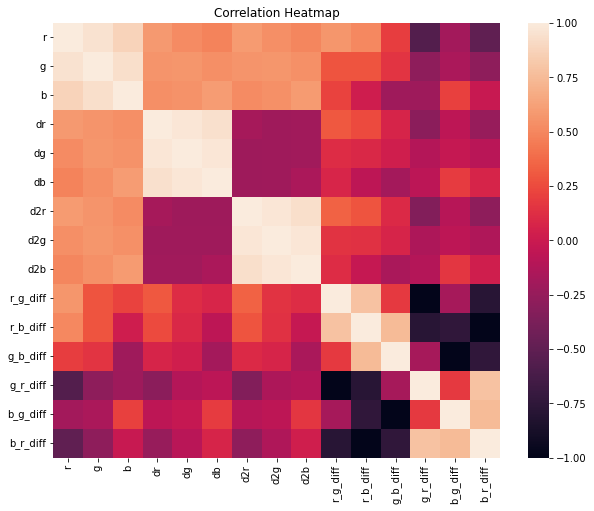

In [156]:
plt.figure(figsize = (10,8))
plt.title('Correlation Heatmap')
sns.heatmap(x_train.corr())
#plt.savefig('correlation.png');

In [119]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [120]:
pca = PCA(n_components=7)
pca_train = pca.fit_transform(scaled_train)
pca_test = pca.transform(scaled_test)
print(pca.explained_variance_ratio_)

[3.93783653e-01 2.53188839e-01 2.32372930e-01 1.02892446e-01
 1.59208259e-02 1.24724582e-03 3.21695252e-04]


In [146]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(pca_train, y_train)
clf.score(pca_test, y_test)

0.03601800900450225

In [122]:
#random guess classifier mean over 500 epochs
accs = []
for i in range(500):
    acc = accuracy_score(y_test, np.random.randint(0, len(df['category'].unique()), len(y_test)))
    accs.append(acc)
np.mean(accs)

0.03322261130565283

In [123]:
classifiers = [
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(25),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]

In [124]:
for clf in classifiers:
    clf.fit(pca_train,y_train)
    preds = clf.predict(pca_test)
    accuracy = accuracy_score(y_test, preds)
    print('Accuracy of {}: {}' .format(clf, accuracy))

Accuracy of SVC(): 0.3341670835417709
Accuracy of RandomForestClassifier(): 0.432216108054027
Accuracy of KNeighborsClassifier(n_neighbors=25): 0.32416208104052024
Accuracy of MLPClassifier(alpha=1, max_iter=1000): 0.3326663331665833
Accuracy of AdaBoostClassifier(): 0.10005002501250625
Accuracy of GaussianNB(): 0.2876438219109555


In [131]:
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [250, 350, 450],
    'max_features': [0.25, 0.5],
    'max_depth' : [15, 25, 50]
    }
    
clf = RandomForestClassifier()
clf_cv = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1)

clf_cv.fit(pca_train, y_train)
print(clf_cv.best_params_)

best_clf = clf_cv.best_estimator_
preds = best_clf.predict(pca_test)
print(accuracy_score(y_test, preds))

{'criterion': 'gini', 'max_depth': 50, 'max_features': 0.25, 'n_estimators': 450}
0.4337168584292146


In [134]:
params = {
    'hidden_layer_sizes' : [(100,), (200)], 
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
    }
    
clf = MLPClassifier(max_iter = 500)
clf_cv = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1)

clf_cv.fit(pca_train, y_train)
print(clf_cv.best_params_)

best_clf = clf_cv.best_estimator_
preds = best_clf.predict(pca_test)
print(accuracy_score(y_test, preds))

{'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'solver': 'adam'}
0.42621310655327665


/Users/ericcriteser/anaconda2/envs/satview/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [139]:
params = {
    'C':[0.1, 1, 100],
    'gamma':[0.01, 0.1, 1]
}
clf = SVC(kernel = 'rbf')
clf_cv = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1)
clf_cv.fit(pca_train, y_train)
print(clf_cv.best_params_)
best_clf = clf_cv.best_estimator_
preds = best_clf.predict(pca_test)
print(accuracy_score(y_test, preds))

{'C': 100, 'gamma': 0.1}
0.4107053526763382


In [173]:
accs = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .5)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 7)),
                 ('rfc', RandomForestClassifier(criterion = 'gini', max_depth = 50, max_features = 0.25, n_estimators = 450))])
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)
    accs.append(accuracy_score(preds, y_test))
print(np.mean(accs))

0.4234940964578747


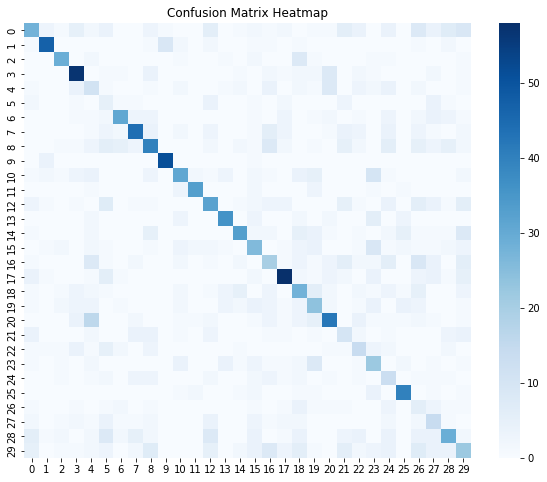

In [166]:
plt.figure(figsize = (10,8))
cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, cmap = 'Blues')
plt.title('Confusion Matrix Heatmap')
#plt.savefig('cm_heatmap.png');

In [185]:
preds = pipe.predict(x_test)

In [206]:
#[10:16] decent representative sample
print(x_test[10:16].index.values)
print(le.inverse_transform(preds[10:16]))
print(le.inverse_transform(y_test[10:16]))

[5782 3933 3845 8886 8802 7080]
['Pond' 'Parking' 'Farmland' 'Meadow' 'MediumResidential' 'BareLand']
['SparseResidential' 'Stadium' 'Farmland' 'Meadow' 'Meadow' 'BareLand']


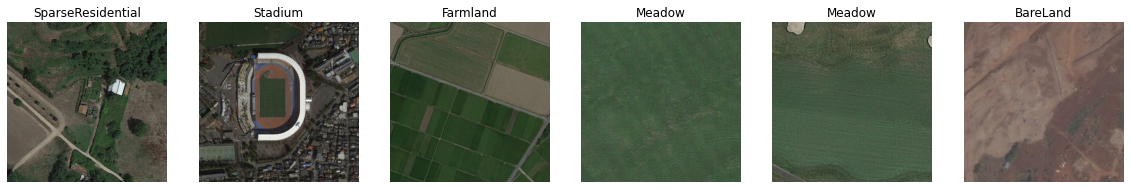

In [226]:
rows = 1
pred_labels = le.inverse_transform(preds[10:16])
idxs = x_test[10:16].index.values
pred_filepaths = df.iloc[idxs]['file_path']
fig = plt.figure(figsize=(20, 10))
plt.tight_layout(pad=1)
for num, x in enumerate(pred_filepaths):
    img = PIL.Image.open(x)
    plt.subplot(rows,6,num+1)
    plt.title(x.split('/')[-2])
    plt.axis('off')
    plt.imshow(img)
#plt.savefig('predictions.png', bbox_inches='tight')